In [84]:
# Import Libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import sklearn 
import scipy
import matplotlib.pyplot as plt
import xgboost as xgb
%matplotlib inline

# Classifier Libraries
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

#Import display settings
from IPython.display import Image
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#Rise Configuration
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'theme': 'sky',
        'scroll': True
})

# Other Libraries
from scipy.stats import mstats
from imblearn.over_sampling import SMOTE 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

# Predicting Player Fantasy Value on FanDuel

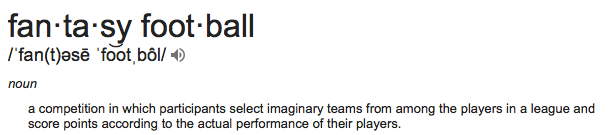

In [85]:
Image(filename = 'FantasyFootball.png', width=800, height=600)

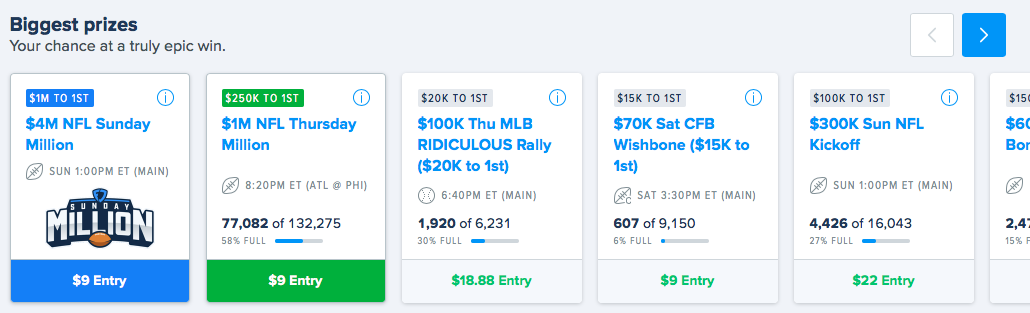

In [86]:
Image(filename = 'GameSlates.png', width=1200, height=800)

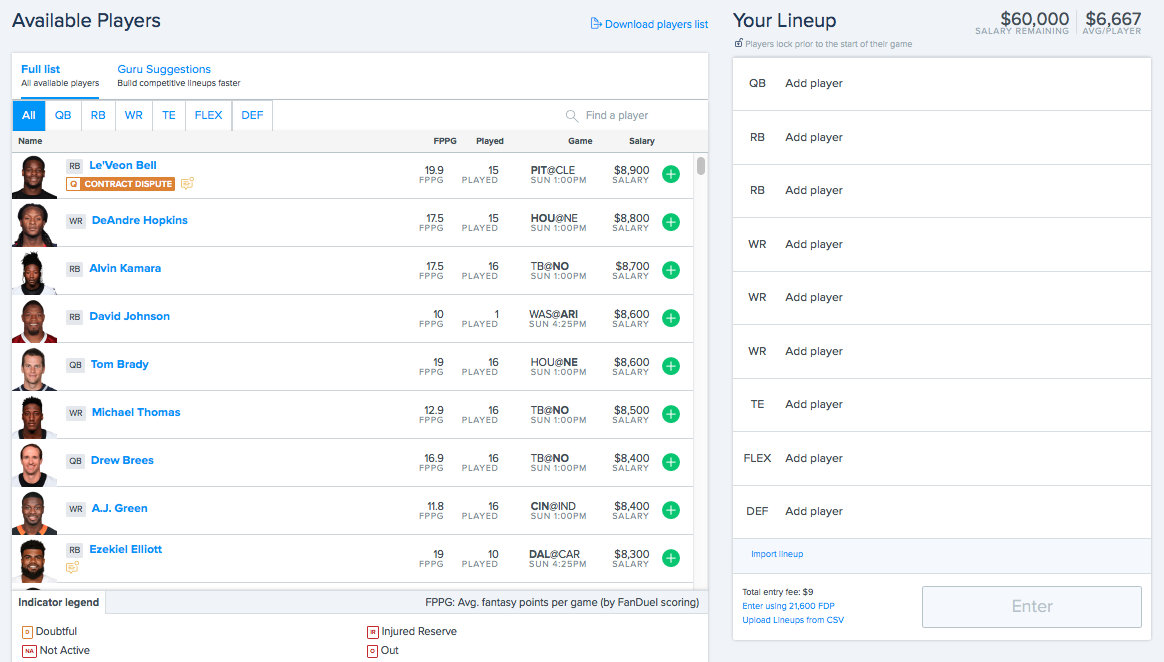

In [87]:
Image(filename = 'Lineups.png', width=1200, height=800)

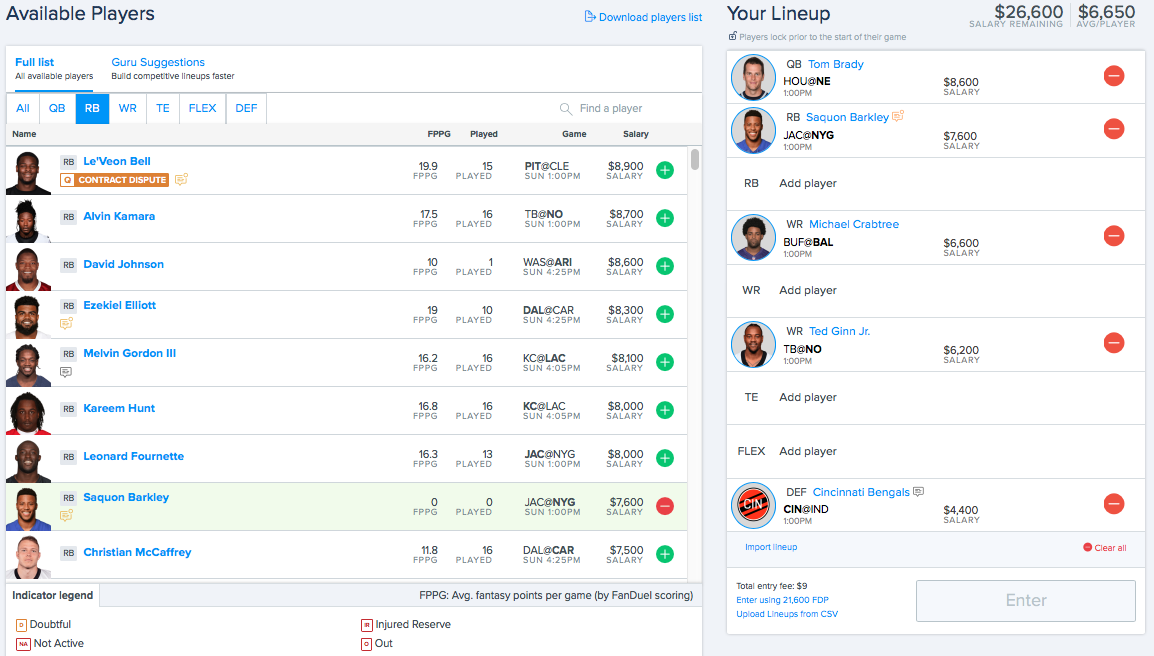

In [88]:
Image(filename = 'Lineups_2.png', width=1200, height=800)

# Data Source
## 1. Armchair Analysis
* Provides comprenhesive NFL data to individuals, researchers and businesses focused on the sport of American Football.
* 785,000+ NFL Plays
* 4,700 Games
* 11,000+ NFL Players
* NFL stats from 2000-2017
* 30 different tables


## 2. Fantasy Data
* Leading provider of sports content solutions, and research tools for the fantasy sports industry. 
* Player salary
* Player fantasy point projections

In [89]:
#Player Background Data
player_path = '/Users/mac/Dropbox/Thinkful_Coursework/Side Projects/ArmchairAnalysis/player.csv'
player_df = pd.read_csv(player_path)
       
#Player Offensive Data
offense_path = '/Users/mac/Dropbox/Thinkful_Coursework/Side Projects/ArmchairAnalysis/offense.csv'
offense_df = pd.read_csv(offense_path)

#Game Data
game_path = '/Users/mac/Dropbox/Thinkful_Coursework/Side Projects/ArmchairAnalysis/game.csv'
game_df = pd.read_csv(game_path)    

#Team Data
team_path = '/Users/mac/Dropbox/Thinkful_Coursework/Side Projects/ArmchairAnalysis/team.csv'
team_df = pd.read_csv(team_path)          

#Team Data Renamed
team_cols = team_df.columns
for cols in team_cols:
    team_cols_new = team_df.rename(columns = {cols :'team_{}'.format(cols)}, inplace=True)
    
    
#Team Defense Data
team_def_df_path = '/Users/mac/Dropbox/Thinkful_Coursework/Side Projects/def_pts_allowed.csv'
team_def_df = pd.read_csv(team_def_df_path)

#Fantasy Data Projections
projections_path = '/Users/mac/Dropbox/Thinkful_Coursework/Side Projects/dfs.projections.v3.csv'
projections_df = pd.read_csv(projections_path)

#Redzone Data
redzone_path = '/Users/mac/Dropbox/Thinkful_Coursework/Side Projects/ArmchairAnalysis/redzone.csv'
redzone_df = pd.read_csv(redzone_path)

#Redzone Data Renamed
redzone_cols = redzone_df.columns
for cols in redzone_cols:
    redzone_cols_new = redzone_df.rename(columns = {cols :'rz_{}'.format(cols)}, inplace=True)
    
#Snap Data
snap_path = '/Users/mac/Dropbox/Thinkful_Coursework/Side Projects/snap_count.v2.csv'
snap_df = pd.read_csv(snap_path)

#Salary Data
fd_salary_path = '/Users/mac/Dropbox/Thinkful_Coursework/Side Projects/fanduel_salaries_2015_2017.csv'
fd_salary_df = pd.read_csv(fd_salary_path)

# Merge Game, Player and Team Data
* 1.) Team shape: (99866, 178) - Initially merged player and team offensive data
* 2.) Player shape: (99866, 204)
* 3.) Game shape: (95784, 219)
* 4.) Defense shape: (96024, 229)
* 5.) Fantasy shape: (113785, 239)
* 6.) Redzone shape: (115809, 254)
* 7.) Snap shape: (122469, 261)
* 8.) Salary shape: (137880, 264)
* Final shape: (46242, 264) - Flitered by last 3 seasons: 2015-2017

In [90]:
#Merge team and player offensive data
team = pd.merge(offense_df, team_df, left_on=['gid','team'], right_on=['team_gid','team_tname'])
print('1. Team shape:', team.shape)

#Add player background data
player = pd.merge(player_df, team, on='player')
print('2. Player shape:', player.shape)

#Add specific game data
game = pd.merge(game_df, player, on=['gid','year'])
game = game[game.week <= 17]
print('3. Game shape:', game.shape)

#Add team defense data
defense = pd.merge(game, team_def_df, left_on=['team', 'year', 'week'], 
                   right_on=['offense', 'year', 'week'], how='outer')
print('4. Defense shape:', defense.shape)

#Add fantasy projections data
fantasy = pd.merge(defense, projections_df, left_on=['fname','lname','year','week','defense'], 
                   right_on=['fname','lname','year','week','opponent'], how='outer')
print('5. Fantasy shape:', fantasy.shape)

#Add redzone data
redzone = pd.merge(fantasy, redzone_df, left_on=['gid','player'], 
                   right_on=['rz_gid','rz_player'], how='outer')
print('6. Redzone shape:', redzone.shape)

#Add snap data
snap = pd.merge(redzone, snap_df, left_on=['fname','lname','year','week','opponent'], 
                   right_on=['fname','lname','year','week','opponent'], how='outer')
print('7. Snap shape:', snap.shape)

#Add fantasy salary data
salary = pd.merge(snap, fd_salary_df, left_on=['fname','lname','pos1','year','week','team','opponent'],
                 right_on=['fname','lname','pos1','year','week','team','opponent'], how='outer')
print('8. Salary shape:', salary.shape)

#Slice final dataframe
final = salary[salary.year >= 2015]
print('9. Final shape:', final.shape)

1. Team shape: (99866, 178)
2. Player shape: (99866, 204)
3. Game shape: (95784, 219)
4. Defense shape: (96024, 229)
5. Fantasy shape: (113785, 239)
6. Redzone shape: (115809, 254)
7. Snap shape: (122469, 261)
8. Salary shape: (137880, 264)
9. Final shape: (46242, 264)


# Feature Engineering: Create Team and Player Features
* 1.) Rolling Averages
    * Previous - 1 week window
    * Recent - 4 week window
    * Season - 16 week window
        
* 2.) Rolling Standard Deviations
    * Recent - 4 week window
    * Season - 16 week window  

In [91]:
def data_processing(df):
    df.sort_values(by = ['player', 'week']) 
    
    #Select player offensive stats to calculate rolling averages
    passing = ['pa','pc','py','tdp','ints']
    rush = ['ra','sra','ry','tdr']
    rec =  ['trg','rec','recy','tdrec']
    kick = ['ret', 'rety', 'tdret']
    other = ['fuml','peny','conv']
    fantasy_pts = ['fp2']
    
    projections = ['proj_py','proj_tdp','proj_ints','proj_ry','proj_tdr',
                   'proj_recy','proj_tdrec','proj_fp2']
    
    redzone = ['rz_pa','rz_pc','rz_py','rz_ints',
              'rz_ra','rz_sra','rz_ry',
              'rz_trg','rz_rec','rz_recy',
              'rz_fuml','rz_peny']
    
    snaps = ['snaps','snaps_%','rsnaps_%','trg_snaps_%',
             't_snaps_%','it_snaps_%','fp2_snaps_%']
                   
    player_stats = passing+rush+rec+kick+other+fantasy_pts+projections+redzone+snaps
    
    #Select team offensive stats to calculate rolling averages
    team_pass = ['team_pfd','team_tdp','team_bpy',
           'team_wr1a','team_wr1y','team_wr3a','team_wr3y',
           'team_tea','team_tey','team_rba','team_rby',
            'team_rzpa','team_rzpy','team_sk','team_sky',
            'team_sga','team_sgy','team_nha']
    
    team_rush = ['team_rfd','team_ra','team_ry','team_bry',
            'team_rzra','team_rzry','team_srp','team_tdr']
    
    team_spec = ['team_pu','team_gpy','team_pr','team_pry',
            'team_kr','team_kry','team_fgm','team_fgat',
             'team_rtd','team_npy']
    
    team_other = ['team_pts','team_top','team_sfpy','team_td',
              'team_rza','team_rzc','team_drv',
              'team_s3a','team_s3c','team_l3a','team_l3c',
              'team_ifd','team_fum','team_pen']
    
    team_def = ['qbfp2','rbfp2','wrfp2','tefp2','kfp2','total_fp2']
    
    team_stats = team_pass+team_rush+team_spec+team_other+team_def
    
    df, player_features = get_player_averages(df, player_stats)
    df, team_features = get_team_averages(df, team_stats)
    
    df, player_stdev_features = get_player_stdevs(df, player_stats)
    df, team_stdev_features = get_team_stdevs(df, team_stats)
    
    features = player_features + team_features + player_stdev_features + team_stdev_features
    
    return df, features

def rolling_average(df, window):
    return df.rolling(min_periods=1, window=window).mean().shift(1)

def rolling_std(df, window):
    return df.rolling(min_periods=1, window=window).std().shift(1)

def get_player_averages(df, player_stats):
    player_feature_names = []
    for stat in df[player_stats]:
        df['season_{}'.format(stat)] = df.groupby('player')[stat].apply(lambda x: rolling_average(x, 16))
        df['recent_{}'.format(stat)] = df.groupby('player')[stat].apply(lambda x: rolling_average(x, 4))
        df['prev_{}'.format(stat)] = df.groupby('player')[stat].apply(lambda x: rolling_average(x, 1))
        player_feature_names = player_feature_names + [time + "_" + stat for time in ['season', 'recent', 'prev']] 
    return df, player_feature_names

def get_player_stdevs(df, player_stats):
    player_stdev_feature_names = []
    for stat in df[player_stats]:
        df['season_stdev_{}'.format(stat)] = df.groupby('player')[stat].apply(lambda x: rolling_std(x, 16))
        df['recent_stdev_{}'.format(stat)] = df.groupby('player')[stat].apply(lambda x: rolling_std(x, 4))
        player_stdev_feature_names = player_stdev_feature_names + [time + "_" + stat for time in ['season_stdev', 'recent_stdev','prev_stdev']] 
    return df, player_stdev_feature_names

def get_team_averages(df, team_stats):
    team_feature_names = []
    for stat in df[team_stats]:
        df['season_{}'.format(stat)] = df.groupby('team')[stat].apply(lambda x: rolling_average(x, 16))
        df['recent_{}'.format(stat)] = df.groupby('team')[stat].apply(lambda x: rolling_average(x, 4))
        df['prev_{}'.format(stat)] = df.groupby('team')[stat].apply(lambda x: rolling_average(x, 1))
        team_feature_names = team_feature_names + [time + "_" + stat for time in ['season', 'recent', 'prev']]
    return df, team_feature_names

def get_team_stdevs(df, team_stats):
    team_stdev_feature_names = []
    for stat in df[team_stats]:
        df['season_stdev_{}'.format(stat)] = df.groupby('player')[stat].apply(lambda x: rolling_std(x, 16))
        df['recent_stdev_{}'.format(stat)] = df.groupby('player')[stat].apply(lambda x: rolling_std(x, 4))
        team_stdev_feature_names = team_stdev_feature_names + [time + "_" + stat for time in ['season_stdev', 'recent_stdev','prev_stdev']] 
    return df, team_stdev_feature_names

# Drop Features Used for Rolling Calculations

In [92]:
df = data_processing(final)[0]
print('Dataframe shape:', df.shape)

Dataframe shape: (46242, 779)


In [93]:
df.head()

,gid,year,week,day,visitor,home,stad,temp,humd,wspd,wdir,cond,surf,ou,sprv,ptsv,ptsh,player,fname,lname,pname,pos1,pos2,height,weight,dob,forty,bench,vertical,broad,shuttle,cone,arm,hand,dpos,col,dv,start,cteam,posd_x,jnum_x,dcp_x,nflid_x,pimg,uid,pa,pc,py,ints,tdp,ra,sra,ry,tdr,trg,rec,recy,tdrec,ret,rety,tdret,fuml,peny,conv,fp,fp2,fp3,game,seas,team,posd_y,jnum_y,dcp_y,nflid_y,team_tid,team_gid,team_tname,team_pts,team_q1p,team_q2p,team_q3p,team_q4p,team_rfd,team_pfd,team_ifd,team_ry,team_ra,team_py,team_pa,team_pc,team_sk,team_ints,team_fum,team_pu,team_gpy,team_pr,team_pry,team_kr,team_kry,team_ir,team_iry,team_pen,team_top,team_td,team_tdr,team_tdp,team_tdt,team_fgm,team_fgat,team_fgy,team_rza,team_rzc,team_bry,team_bpy,team_srp,team_s1rp,team_s2rp,team_s3rp,team_spp,team_s1pp,team_s2pp,team_s3pp,team_lea,team_ley,team_lta,team_lty,team_lga,team_lgy,team_mda,team_mdy,team_rga,team_rgy,team_rta,team_rty,team_rea,team_rey,team_r1a,team_r1y,team_r2a,team_r2y,team_r3a,team_r3y,team_qba,team_qby,team_sla,team_sly,team_sma,team_smy,team_sra,team_sry,team_dla,team_dly,team_dma,team_dmy,team_dra,team_dry,team_wr1a,team_wr1y,team_wr3a,team_wr3y,team_tea,team_tey,team_rba,team_rby,team_sga,team_sgy,team_p1a,team_p1y,team_p2a,team_p2y,team_p3a,team_p3y,team_spc,team_mpc,team_lpc,team_q1ra,team_q1ry,team_q1pa,team_q1py,team_lcra,team_lcry,team_lcpa,team_lcpy,team_rzra,team_rzry,team_rzpa,team_rzpy,team_sky,team_lbs,team_dbs,team_sfpy,team_drv,team_npy,team_tb,team_i20,team_rtd,team_lnr,team_lnp,team_lbr,team_lbp,team_dbr,team_dbp,team_nha,team_s3a,team_s3c,team_l3a,team_l3c,team_stf,team_dp,team_fsp,team_ohp,team_pbep,team_dlp,team_dsp,team_dum,team_pfn,team_saf,team_blk,team_fp,name,defense,position,offense,qbfp2,rbfp2,wrfp2,tefp2,kfp2,total_fp2,opponent,proj_py,proj_tdp,proj_ints,proj_ry,proj_tdr,proj_rec,proj_recy,proj_tdrec,proj_fp2,rz_uid,rz_gid,rz_player,rz_pa,rz_pc,rz_py,rz_ints,rz_ra,rz_sra,rz_ry,rz_trg,...,recent_team_rzc,prev_team_rzc,season_team_drv,recent_team_drv,prev_team_drv,season_team_s3a,recent_team_s3a,prev_team_s3a,season_team_s3c,recent_team_s3c,prev_team_s3c,season_team_l3a,recent_team_l3a,prev_team_l3a,season_team_l3c,recent_team_l3c,prev_team_l3c,season_team_ifd,recent_team_ifd,prev_team_ifd,season_team_fum,recent_team_fum,prev_team_fum,season_team_pen,recent_team_pen,prev_team_pen,season_qbfp2,recent_qbfp2,prev_qbfp2,season_rbfp2,recent_rbfp2,prev_rbfp2,season_wrfp2,recent_wrfp2,prev_wrfp2,season_tefp2,recent_tefp2,prev_tefp2,season_kfp2,recent_kfp2,prev_kfp2,season_total_fp2,recent_total_fp2,prev_total_fp2,season_stdev_pa,recent_stdev_pa,season_stdev_pc,recent_stdev_pc,season_stdev_py,recent_stdev_py,season_stdev_tdp,recent_stdev_tdp,season_stdev_ints,recent_stdev_ints,season_stdev_ra,recent_stdev_ra,season_stdev_sra,recent_stdev_sra,season_stdev_ry,recent_stdev_ry,season_stdev_tdr,recent_stdev_tdr,season_stdev_trg,recent_stdev_trg,season_stdev_rec,recent_stdev_rec,season_stdev_recy,recent_stdev_recy,season_stdev_tdrec,recent_stdev_tdrec,season_stdev_ret,recent_stdev_ret,season_stdev_rety,recent_stdev_rety,season_stdev_tdret,recent_stdev_tdret,season_stdev_fuml,recent_stdev_fuml,season_stdev_peny,recent_stdev_peny,season_stdev_conv,recent_stdev_conv,season_stdev_fp2,recent_stdev_fp2,season_stdev_proj_py,recent_stdev_proj_py,season_stdev_proj_tdp,recent_stdev_proj_tdp,season_stdev_proj_ints,recent_stdev_proj_ints,season_stdev_proj_ry,recent_stdev_proj_ry,season_stdev_proj_tdr,recent_stdev_proj_tdr,season_stdev_proj_recy,recent_stdev_proj_recy,season_stdev_proj_tdrec,recent_stdev_proj_tdrec,season_stdev_proj_fp2,recent_stdev_proj_fp2,season_stdev_rz_pa,recent_stdev_rz_pa,season_stdev_rz_pc,recent_stdev_rz_pc,season_stdev_rz_py,recent_stdev_rz_py,season_stdev_rz_ints,recent_stdev_rz_ints,season_stdev_rz_ra,recent_stdev_rz_ra,season_stdev_rz_sra,recent_stdev_rz_sra,season_stdev_rz_ry,recent_stdev_rz_ry,season_stdev_rz_trg,recent_stdev_rz_trg,season_stdev_rz_rec,recent_stdev_rz_rec,season_stdev_rz_recy,recent_st

In [94]:
#Drop player and team stats used to calculate rolling averages
passing = ['pa','pc','py','tdp','ints']
rush = ['ra','sra','ry','tdr']
rec =  ['trg','rec','recy','tdrec']
kick = ['ret', 'rety', 'tdret']
other = ['fuml','peny','conv']

redzone = ['rz_pa','rz_pc','rz_py','rz_ints',
           'rz_ra','rz_sra','rz_ry',
           'rz_trg','rz_rec','rz_recy',
           'rz_fuml','rz_peny','rz_player',
           'rz_uid','rz_gid']

snaps = ['snaps','snaps_%','rsnaps_%','trg_snaps_%',
             't_snaps_%','it_snaps_%','fp2_snaps_%']
                   
player_drops = passing+rush+rec+kick+other+redzone+snaps

team_drops = team_df.columns

#Drop game conditions data that does not have rolling averages
game_drops = ['humd','wspd','wdir','temp','cond']

#Drop other columns from df 
other_drops = ['ptsv','ptsh','pname','fname','lname','pos2','cteam',
              'posd_x','posd_y','nflid_x','nflid_y','jnum_x', 'jnum_y','pimg',
               'uid','game','dcp_y']

#Drop team defense data 
defense_drops = ['qbfp2','rbfp2','wrfp2','tefp2','kfp2','total_fp2',
                'name','position',]

df.drop(player_drops, inplace=True, axis=1)
df.drop(team_drops, inplace=True, axis=1)
df.drop(game_drops, inplace=True, axis=1)
df.drop(other_drops, inplace=True, axis=1)
df.drop(defense_drops, inplace=True, axis=1)

In [95]:
print('Dataframe shape after drops:', df.shape)

Dataframe shape after drops: (46242, 563)


* Dataframe shape after drops: (46242, 574)
* 299 New Features added

# Data Cleaning, Missingness and DataTypes

In [96]:
x = 93

# Check data types
print('Column Data Types')
print('-' *x)
print(df.dtypes)
print('-' *x)

# Check for missing data
print('Missing Data in Dataframe')
print('-' *x)
print(df.isnull().sum().sort_values(ascending=False))
print('-' *x)

# Check for outliers
print('Column Summary')
print('-' *x)
df.describe().transpose()

Column Data Types
---------------------------------------------------------------------------------------------
gid                        object
year                      float64
week                      float64
day                        object
visitor                    object
home                       object
stad                       object
surf                       object
ou                        float64
sprv                      float64
player                     object
pos1                       object
height                    float64
weight                    float64
dob                        object
forty                     float64
bench                     float64
vertical                  float64
broad                     float64
shuttle                   float64
cone                      float64
arm                       float64
hand                      float64
dpos                      float64
col                        object
dv                         object
star

,count,mean,std,min,25%,50%,75%,max
year,46242.0,2016.030470,0.794192,2015.000000,2015.000000,2016.000000,2017.000000,2017.000000
week,46242.0,9.208447,5.008316,1.000000,5.000000,9.000000,14.000000,17.000000
ou,16234.0,44.860201,3.731328,36.500000,42.000000,44.500000,47.500000,56.500000
sprv,16234.0,2.046877,5.412978,-11.500000,-3.000000,3.000000,6.000000,17.000000
height,16234.0,73.075151,2.985130,66.000000,71.000000,73.000000,75.000000,81.000000
weight,16234.0,217.825428,24.233514,149.000000,200.000000,215.000000,234.000000,346.000000
forty,16234.0,4.136439,1.332386,0.000000,4.400000,4.510000,4.640000,5.380000
bench,16234.0,12.119194,9.602737,0.000000,0.000000,14.000000,20.000000,44.000000
vertical,16234.0,28.793951,13.621144,0.000000,31.000000,34.000000,36.500000,45.000000
broad,16234.0,95.331157,48.206375,0.000000,109.000000,118.000000,122.000000,139.000000


In [97]:
#Fill NaN rows with NaN 0
df = df.fillna(0)

# Convert Objects to Categorical Variables

In [98]:
#Convert object columns to categorical variables
object_cols = df.select_dtypes(['object']).columns.tolist()

#Create feature for home/visitor teams
df['team_vis'] = (df['team'] == df['visitor']).astype(int)
df['team_home'] = (df['team'] == df['home']).astype(int)

#Create player's age feature
df['dob'] = pd.to_datetime(df['dob'])
df['dob_year'] = df['dob'].dt.year
df['player_age'] = df['year'] - df['dob_year']

for cols in object_cols:
    df[cols] = df[cols].astype('category')
    df['{}_num'.format(cols)] = pd.Categorical(df[cols]).codes
    
#Create cateorical feature mapping
day_map = df[['day','day_num']].drop_duplicates()
stad_map = df[['stad','stad_num']].drop_duplicates()
surf_map = df[['surf','surf_num']].drop_duplicates()
player_map = df[['player','player_num']].drop_duplicates()
pos1_map = df[['pos1','pos1_num']].drop_duplicates()
col_map = df[['col','col_num']].drop_duplicates()
dv_map = df[['dv','dv_num']].drop_duplicates()
team_map = df[['team','team_num']].drop_duplicates()
offense_map = df[['offense','offense_num']].drop_duplicates()
defense_map = df[['defense','defense_num']].drop_duplicates()
opponent_map = df[['opponent','opponent_num']].drop_duplicates()

# Drop time dependent and non numeric categorical variables

In [99]:
final_drops = ['gid','day','visitor','home','stad','surf','pos1',
               'dob','col','dv','team','dob_year','visitor_num',
              'home_num','dob_num','offense','defense','opponent']

df.drop(final_drops, inplace=True, axis=1)

# Feature Engineering - Game Performance

In [100]:
#Create Actual Deviation feature
df['recent_dev'] = (df.fp2 - df.recent_fp2)
df['season_dev'] = (df.fp2 - df.season_fp2)

#Create Fantasy performance feature
df['recent_perf'] = df.recent_dev / df.recent_stdev_fp2
df['season_perf'] = df.season_dev / df.season_stdev_fp2

#Drop rows with data type inf
df.replace([np.inf, -np.inf], np.nan,inplace=True, axis=1)
df = df.fillna(0)

In [101]:
#Create function to categorize expected performance
def fantasymapper(ftmp):
    if ftmp > 0:
        return 'Stud'
    else:
        return 'Dud'

#Add performance labels 
df['recent_perf_label'] = df.recent_perf.apply(lambda x: fantasymapper(x))
df['season_perf_label'] = df.season_perf.apply(lambda x: fantasymapper(x))

#Add rolling averages recent performances
df['recent_studs'] = df.groupby(['player','year','week']).recent_perf_label.apply(lambda x: (x =='Stud').rolling(4, min_periods=1).sum())
df['recent_duds'] = df.groupby(['player','year','week']).recent_perf_label.apply(lambda x: (x =='Dud').rolling(4, min_periods=1).sum())

df['recent_studs'] = df.recent_studs.rolling(4, min_periods=1).sum().shift(1)
df['recent_duds'] = df.recent_duds.rolling(4, min_periods=1).sum().shift(1)

# #Add rolling averages season performances
df['season_studs'] = df.groupby(['player','year','week']).season_perf_label.apply(lambda x: (x =='Stud').rolling(16, min_periods=1).sum())
df['season_duds'] = df.groupby(['player','year','week']).season_perf_label.apply(lambda x: (x =='Dud').rolling(16, min_periods=1).sum())

df['season_studs'] = df.season_studs.rolling(16, min_periods=1).sum().shift(1)
df['season_duds'] = df.season_duds.rolling(16, min_periods=1).sum().shift(1)

In [102]:
df.head()

,year,week,ou,sprv,player,height,weight,forty,bench,vertical,broad,shuttle,cone,arm,hand,dpos,start,dcp_x,fp,fp2,fp3,seas,proj_py,proj_tdp,proj_ints,proj_ry,proj_tdr,proj_rec,proj_recy,proj_tdrec,proj_fp2,opp_rank,opp_rpos_rank,fd_salary,season_pa,recent_pa,prev_pa,season_pc,recent_pc,prev_pc,season_py,recent_py,prev_py,season_tdp,recent_tdp,prev_tdp,season_ints,recent_ints,prev_ints,season_ra,recent_ra,prev_ra,season_sra,recent_sra,prev_sra,season_ry,recent_ry,prev_ry,season_tdr,recent_tdr,prev_tdr,season_trg,recent_trg,prev_trg,season_rec,recent_rec,prev_rec,season_recy,recent_recy,prev_recy,season_tdrec,recent_tdrec,prev_tdrec,season_ret,recent_ret,prev_ret,season_rety,recent_rety,prev_rety,season_tdret,recent_tdret,prev_tdret,season_fuml,recent_fuml,prev_fuml,season_peny,recent_peny,prev_peny,season_conv,recent_conv,prev_conv,season_fp2,recent_fp2,prev_fp2,season_proj_py,recent_proj_py,prev_proj_py,season_proj_tdp,recent_proj_tdp,prev_proj_tdp,season_proj_ints,recent_proj_ints,prev_proj_ints,season_proj_ry,recent_proj_ry,prev_proj_ry,season_proj_tdr,recent_proj_tdr,prev_proj_tdr,season_proj_recy,recent_proj_recy,prev_proj_recy,season_proj_tdrec,recent_proj_tdrec,prev_proj_tdrec,season_proj_fp2,recent_proj_fp2,prev_proj_fp2,season_rz_pa,recent_rz_pa,prev_rz_pa,season_rz_pc,recent_rz_pc,prev_rz_pc,season_rz_py,recent_rz_py,prev_rz_py,season_rz_ints,recent_rz_ints,prev_rz_ints,season_rz_ra,recent_rz_ra,prev_rz_ra,season_rz_sra,recent_rz_sra,prev_rz_sra,season_rz_ry,recent_rz_ry,prev_rz_ry,season_rz_trg,recent_rz_trg,prev_rz_trg,season_rz_rec,recent_rz_rec,prev_rz_rec,season_rz_recy,recent_rz_recy,prev_rz_recy,season_rz_fuml,recent_rz_fuml,prev_rz_fuml,season_rz_peny,recent_rz_peny,prev_rz_peny,season_snaps,recent_snaps,prev_snaps,season_snaps_%,recent_snaps_%,prev_snaps_%,season_rsnaps_%,recent_rsnaps_%,prev_rsnaps_%,season_trg_snaps_%,recent_trg_snaps_%,prev_trg_snaps_%,season_t_snaps_%,recent_t_snaps_%,prev_t_snaps_%,season_it_snaps_%,recent_it_snaps_%,prev_it_snaps_%,season_fp2_snaps_%,recent_fp2_snaps_%,prev_fp2_snaps_%,season_team_pfd,recent_team_pfd,prev_team_pfd,season_team_tdp,recent_team_tdp,prev_team_tdp,season_team_bpy,recent_team_bpy,prev_team_bpy,season_team_wr1a,recent_team_wr1a,prev_team_wr1a,season_team_wr1y,recent_team_wr1y,prev_team_wr1y,season_team_wr3a,recent_team_wr3a,prev_team_wr3a,season_team_wr3y,recent_team_wr3y,prev_team_wr3y,season_team_tea,recent_team_tea,prev_team_tea,season_team_tey,recent_team_tey,prev_team_tey,season_team_rba,recent_team_rba,prev_team_rba,season_team_rby,recent_team_rby,prev_team_rby,season_team_rzpa,recent_team_rzpa,prev_team_rzpa,season_team_rzpy,recent_team_rzpy,prev_team_rzpy,season_team_sk,recent_team_sk,prev_team_sk,season_team_sky,recent_team_sky,prev_team_sky,season_team_sga,recent_team_sga,prev_team_sga,season_team_sgy,recent_team_sgy,prev_team_sgy,season_team_nha,recent_team_nha,prev_team_nha,season_team_rfd,recent_team_rfd,prev_team_rfd,season_team_ra,recent_team_ra,prev_team_ra,season_team_ry,recent_team_ry,prev_team_ry,season_team_bry,recent_team_bry,prev_team_bry,season_team_rzra,recent_team_rzra,prev_team_rzra,season_team_rzry,recent_team_rzry,prev_team_rzry,season_team_srp,recent_team_srp,prev_team_srp,...,recent_team_pen,prev_team_pen,season_qbfp2,recent_qbfp2,prev_qbfp2,season_rbfp2,recent_rbfp2,prev_rbfp2,season_wrfp2,recent_wrfp2,prev_wrfp2,season_tefp2,recent_tefp2,prev_tefp2,season_kfp2,recent_kfp2,prev_kfp2,season_total_fp2,recent_total_fp2,prev_total_fp2,season_stdev_pa,recent_stdev_pa,season_stdev_pc,recent_stdev_pc,season_stdev_py,recent_stdev_py,season_stdev_tdp,recent_stdev_tdp,season_stdev_ints,recent_stdev_ints,season_stdev_ra,recent_stdev_ra,season_stdev_sra,recent_stdev_sra,season_stdev_ry,recent_stdev_ry,season_stdev_tdr,recent_stdev_tdr,season_stdev_trg,recent_stdev_trg,season_stdev_rec,recent_stdev_rec,season_stdev_recy,recent_stdev_recy,season_stdev_tdrec,recent_stdev_tdrec,season_stdev_ret,recent_stdev_ret,season_stdev_rety,recent_stdev_rety

# Feature Engineering - Y Variable - Player Value 

In [103]:
#Create feature to evaluate player value
df['player_value'] = (df.fp2 * 1000) / (df.fd_salary)

#Drop rows with data type inf
df.replace([np.inf, -np.inf], np.nan,inplace=True, axis=1)
df = df.fillna(0)

#Check outliers in player value feature
print('-' *x)
print('Player Value Analysis')
print('-' *x)
print(df.player_value.describe())
print('-' *x)

---------------------------------------------------------------------------------------------
Player Value Analysis
---------------------------------------------------------------------------------------------
count    46242.000000
mean         0.335890
std          0.805151
min         -0.526667
25%          0.000000
50%          0.000000
75%          0.000000
max          6.964286
Name: player_value, dtype: float64
---------------------------------------------------------------------------------------------


In [104]:
df.head()

,year,week,ou,sprv,player,height,weight,forty,bench,vertical,broad,shuttle,cone,arm,hand,dpos,start,dcp_x,fp,fp2,fp3,seas,proj_py,proj_tdp,proj_ints,proj_ry,proj_tdr,proj_rec,proj_recy,proj_tdrec,proj_fp2,opp_rank,opp_rpos_rank,fd_salary,season_pa,recent_pa,prev_pa,season_pc,recent_pc,prev_pc,season_py,recent_py,prev_py,season_tdp,recent_tdp,prev_tdp,season_ints,recent_ints,prev_ints,season_ra,recent_ra,prev_ra,season_sra,recent_sra,prev_sra,season_ry,recent_ry,prev_ry,season_tdr,recent_tdr,prev_tdr,season_trg,recent_trg,prev_trg,season_rec,recent_rec,prev_rec,season_recy,recent_recy,prev_recy,season_tdrec,recent_tdrec,prev_tdrec,season_ret,recent_ret,prev_ret,season_rety,recent_rety,prev_rety,season_tdret,recent_tdret,prev_tdret,season_fuml,recent_fuml,prev_fuml,season_peny,recent_peny,prev_peny,season_conv,recent_conv,prev_conv,season_fp2,recent_fp2,prev_fp2,season_proj_py,recent_proj_py,prev_proj_py,season_proj_tdp,recent_proj_tdp,prev_proj_tdp,season_proj_ints,recent_proj_ints,prev_proj_ints,season_proj_ry,recent_proj_ry,prev_proj_ry,season_proj_tdr,recent_proj_tdr,prev_proj_tdr,season_proj_recy,recent_proj_recy,prev_proj_recy,season_proj_tdrec,recent_proj_tdrec,prev_proj_tdrec,season_proj_fp2,recent_proj_fp2,prev_proj_fp2,season_rz_pa,recent_rz_pa,prev_rz_pa,season_rz_pc,recent_rz_pc,prev_rz_pc,season_rz_py,recent_rz_py,prev_rz_py,season_rz_ints,recent_rz_ints,prev_rz_ints,season_rz_ra,recent_rz_ra,prev_rz_ra,season_rz_sra,recent_rz_sra,prev_rz_sra,season_rz_ry,recent_rz_ry,prev_rz_ry,season_rz_trg,recent_rz_trg,prev_rz_trg,season_rz_rec,recent_rz_rec,prev_rz_rec,season_rz_recy,recent_rz_recy,prev_rz_recy,season_rz_fuml,recent_rz_fuml,prev_rz_fuml,season_rz_peny,recent_rz_peny,prev_rz_peny,season_snaps,recent_snaps,prev_snaps,season_snaps_%,recent_snaps_%,prev_snaps_%,season_rsnaps_%,recent_rsnaps_%,prev_rsnaps_%,season_trg_snaps_%,recent_trg_snaps_%,prev_trg_snaps_%,season_t_snaps_%,recent_t_snaps_%,prev_t_snaps_%,season_it_snaps_%,recent_it_snaps_%,prev_it_snaps_%,season_fp2_snaps_%,recent_fp2_snaps_%,prev_fp2_snaps_%,season_team_pfd,recent_team_pfd,prev_team_pfd,season_team_tdp,recent_team_tdp,prev_team_tdp,season_team_bpy,recent_team_bpy,prev_team_bpy,season_team_wr1a,recent_team_wr1a,prev_team_wr1a,season_team_wr1y,recent_team_wr1y,prev_team_wr1y,season_team_wr3a,recent_team_wr3a,prev_team_wr3a,season_team_wr3y,recent_team_wr3y,prev_team_wr3y,season_team_tea,recent_team_tea,prev_team_tea,season_team_tey,recent_team_tey,prev_team_tey,season_team_rba,recent_team_rba,prev_team_rba,season_team_rby,recent_team_rby,prev_team_rby,season_team_rzpa,recent_team_rzpa,prev_team_rzpa,season_team_rzpy,recent_team_rzpy,prev_team_rzpy,season_team_sk,recent_team_sk,prev_team_sk,season_team_sky,recent_team_sky,prev_team_sky,season_team_sga,recent_team_sga,prev_team_sga,season_team_sgy,recent_team_sgy,prev_team_sgy,season_team_nha,recent_team_nha,prev_team_nha,season_team_rfd,recent_team_rfd,prev_team_rfd,season_team_ra,recent_team_ra,prev_team_ra,season_team_ry,recent_team_ry,prev_team_ry,season_team_bry,recent_team_bry,prev_team_bry,season_team_rzra,recent_team_rzra,prev_team_rzra,season_team_rzry,recent_team_rzry,prev_team_rzry,season_team_srp,recent_team_srp,prev_team_srp,...,prev_team_pen,season_qbfp2,recent_qbfp2,prev_qbfp2,season_rbfp2,recent_rbfp2,prev_rbfp2,season_wrfp2,recent_wrfp2,prev_wrfp2,season_tefp2,recent_tefp2,prev_tefp2,season_kfp2,recent_kfp2,prev_kfp2,season_total_fp2,recent_total_fp2,prev_total_fp2,season_stdev_pa,recent_stdev_pa,season_stdev_pc,recent_stdev_pc,season_stdev_py,recent_stdev_py,season_stdev_tdp,recent_stdev_tdp,season_stdev_ints,recent_stdev_ints,season_stdev_ra,recent_stdev_ra,season_stdev_sra,recent_stdev_sra,season_stdev_ry,recent_stdev_ry,season_stdev_tdr,recent_stdev_tdr,season_stdev_trg,recent_stdev_trg,season_stdev_rec,recent_stdev_rec,season_stdev_recy,recent_stdev_recy,season_stdev_tdrec,recent_stdev_tdrec,season_stdev_ret,recent_stdev_ret,season_stdev_rety,recent_stdev_rety,season_stdev_td

# Outcome Variable Visualizations

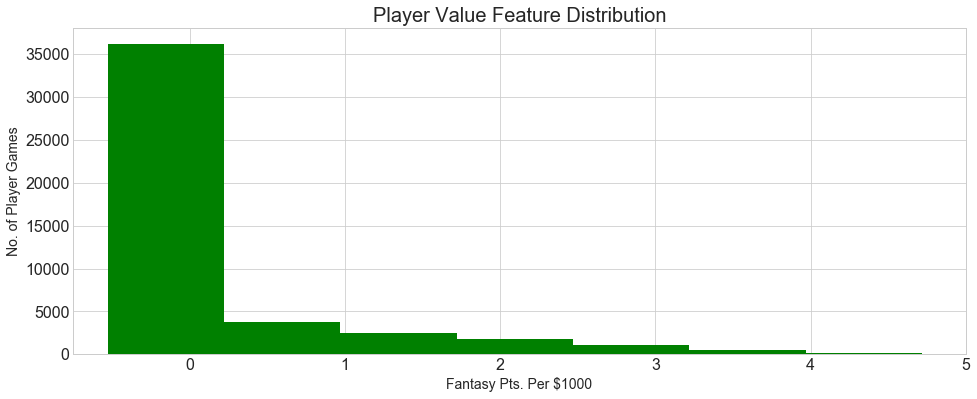

In [105]:
#Plot Player Value Feature Distribution
plt.figure(figsize=(16,6))

plt.hist(df['player_value'], color='green', bins = 10)

plt.title('Player Value Feature Distribution', fontsize=20)
plt.ylabel('No. of Player Games', fontsize=14)
plt.xlabel('Fantasy Pts. Per $1000', fontsize=14)
plt.xlim(-.75,5)

plt.show()

# Visualizations: 
## Player Value by Position

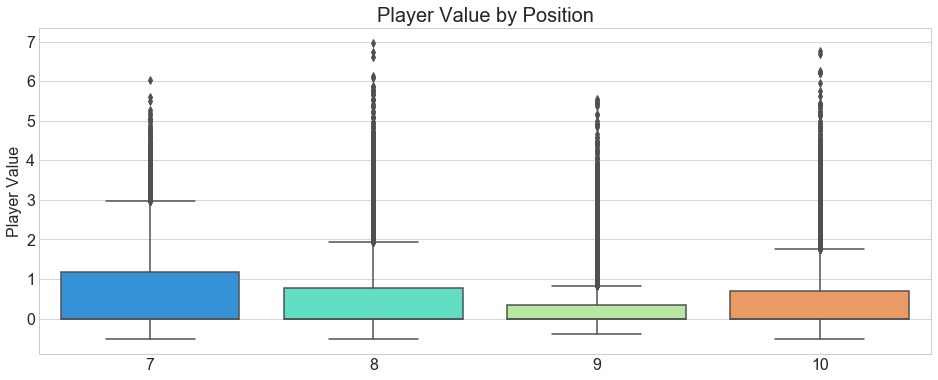

      pos1  pos1_num
79550   WR        10
79551   QB         7
79552   RB         8
79555   TE         9


In [106]:
#Plot Player Value by Position
pos_temp = pd.merge(df, pos1_map, on='pos1_num')
pos_temp = pos_temp[pos_temp.pos1_num >=7]

plt.figure(figsize=(16,6))

sns.boxplot(data = pos_temp, x = 'pos1_num', y = 'player_value', palette='rainbow')
sns.set_style("whitegrid")

plt.xlabel('', fontsize=12)
plt.ylabel('Player Value', fontsize=16)
plt.title('Player Value by Position',fontsize=20) 

plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16

plt.show()

print(pos1_map.head(4))

## Player Value by Draft Position

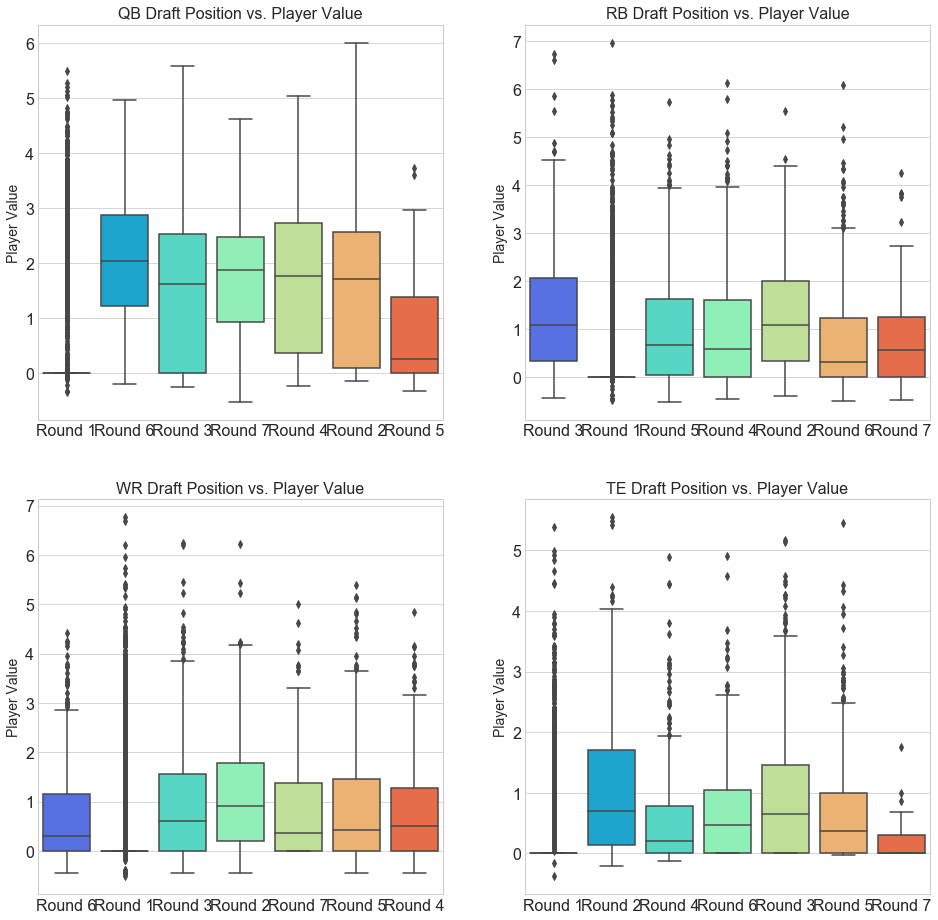

In [107]:
#Map Player Draft Position to Draft Rounds
def draftmapper(dft):
    if dft < 33:
        return 'Round 1'
    if dft < 65:
        return 'Round 2'
    if dft < 101:
        return 'Round 3'
    if dft < 138: 
        return 'Round 4'
    if dft < 175:
        return 'Round 5'
    if dft < 219:
        return 'Round 6'
    else:
        return 'Round 7'

#Apply Draft Mapper to DataFrame    
dpos_df = df
dpos_df['draft_round'] = df.dpos.apply(lambda x: draftmapper(x))

#Subplots of Categorical Features vs Player Value
sns.set_style('whitegrid')
f, axes = plt.subplots(2,2, figsize = (16,16))

#Plot QB Draft Position vs. Player Value
dpos_df = df[df.pos1_num == 7]
sns.boxplot(data = dpos_df, x = 'draft_round', y = 'player_value', palette='rainbow', ax = axes[0,0])
axes[0,0].set_xlabel('', fontsize=14)
axes[0,0].set_ylabel('Player Value', fontsize=14)
axes[0,0].set_title('QB Draft Position vs. Player Value', fontsize=16)

#Plot RB Draft Position vs. Player Value
dpos_df = df[df.pos1_num == 8]
sns.boxplot(data = dpos_df, x = 'draft_round', y = 'player_value', palette='rainbow', ax = axes[0,1])
axes[0,1].set_xlabel('', fontsize=14)
axes[0,1].set_ylabel('Player Value', fontsize=14)
axes[0,1].set_title('RB Draft Position vs. Player Value', fontsize=16)

#Plot WR Draft Position vs. Player Value
dpos_df = df[df.pos1_num == 10]
sns.boxplot(data = dpos_df, x = 'draft_round', y = 'player_value', palette='rainbow', ax = axes[1,0])
axes[1,0].set_xlabel('', fontsize=14)
axes[1,0].set_ylabel('Player Value', fontsize=14)
axes[1,0].set_title('WR Draft Position vs. Player Value', fontsize=16)

#Plot TE Draft Position vs. Player Value
dpos_df = df[df.pos1_num == 9]
sns.boxplot(data = dpos_df, x = 'draft_round', y = 'player_value', palette='rainbow', ax = axes[1,1])
axes[1,1].set_xlabel('', fontsize=14)
axes[1,1].set_ylabel('Player Value', fontsize=14)
axes[1,1].set_title('TE Draft Position vs. Player Value', fontsize=16)

plt.show()

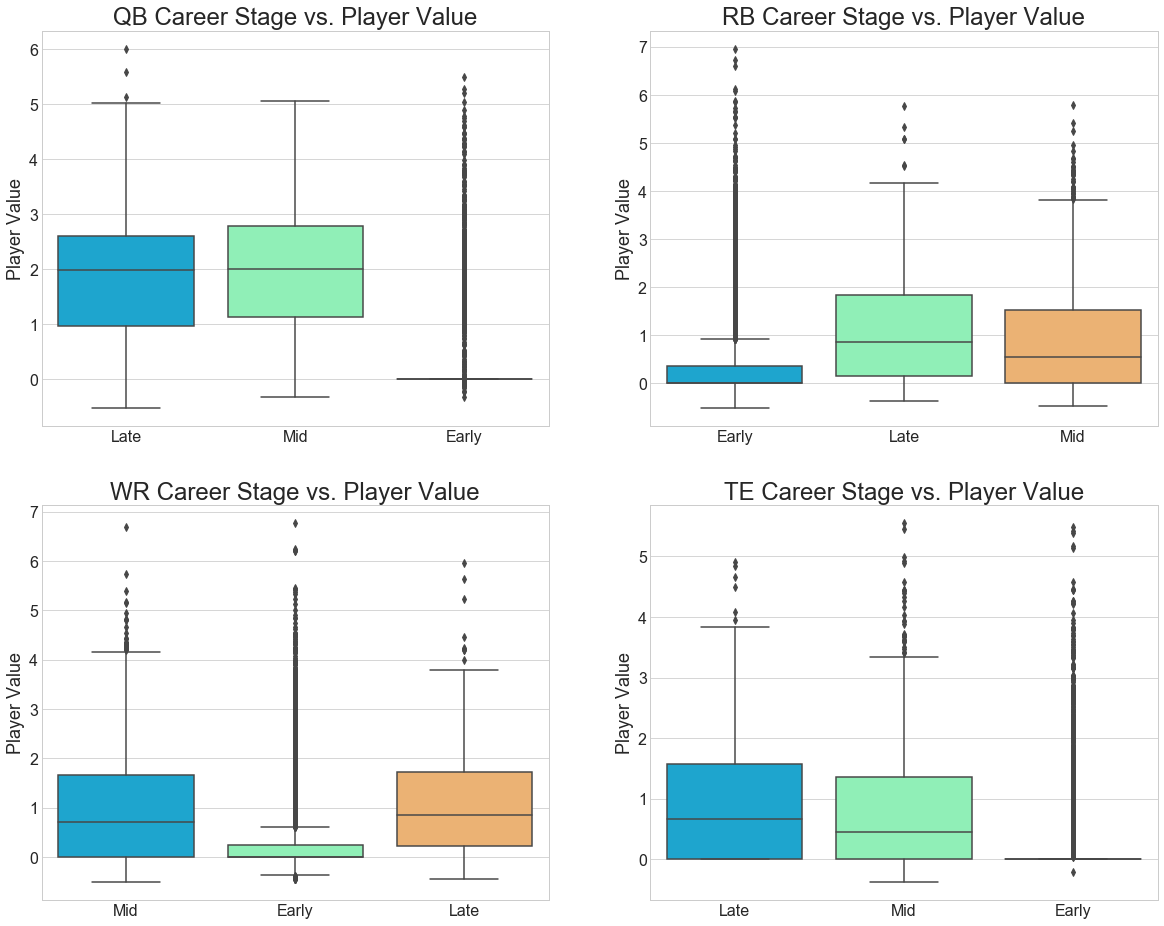

In [108]:
#Map Player Seasons Played to Career Stage
def experiencemapper(exp):
    if exp < 5:
        return 'Early'
    if exp < 10:
        return 'Mid'
    else:
        return 'Late'

#Subplots of Categorical Features vs Player Value
sns.set_style('whitegrid')
f, axes = plt.subplots(2,2, figsize = (20,16))
seas_df = df
seas_df['career'] = df.seas.apply(lambda x: experiencemapper(x))

#Plot QB Seasons Played vs. Player Value
seas_df = df[df.pos1_num == 7]
sns.boxplot(data = seas_df, x = 'career', y = 'player_value', palette='rainbow', ax = axes[0,0])
axes[0,0].set_xlabel('', fontsize=18)
axes[0,0].set_ylabel('Player Value', fontsize=18)
axes[0,0].set_title('QB Career Stage vs. Player Value', fontsize=24)

#Plot RB Seasons Played vs. Player Value
seas_df = df[df.pos1_num == 8]
sns.boxplot(data = seas_df, x = 'career', y = 'player_value', palette='rainbow', ax = axes[0,1])
axes[0,1].set_xlabel('', fontsize=18)
axes[0,1].set_ylabel('Player Value', fontsize=18)
axes[0,1].set_title('RB Career Stage vs. Player Value', fontsize=24)

#Plot WR Seasons Played vs. Player Value
seas_df = df[df.pos1_num == 10]
sns.boxplot(data = seas_df, x = 'career', y = 'player_value', palette='rainbow', ax = axes[1,0])
axes[1,0].set_xlabel('', fontsize=18)
axes[1,0].set_ylabel('Player Value', fontsize=18)
axes[1,0].set_title('WR Career Stage vs. Player Value', fontsize=24)

#Plot TE Seasons Played vs. Player Value
seas_df = df[df.pos1_num == 9]
sns.boxplot(data = seas_df, x = 'career', y = 'player_value', palette='rainbow', ax = axes[1,1])
axes[1,1].set_xlabel('', fontsize=18)
axes[1,1].set_ylabel('Player Value', fontsize=18)
axes[1,1].set_title('TE Career Stage vs. Player Value', fontsize=24)

plt.show()

## Player Value by Speed Type

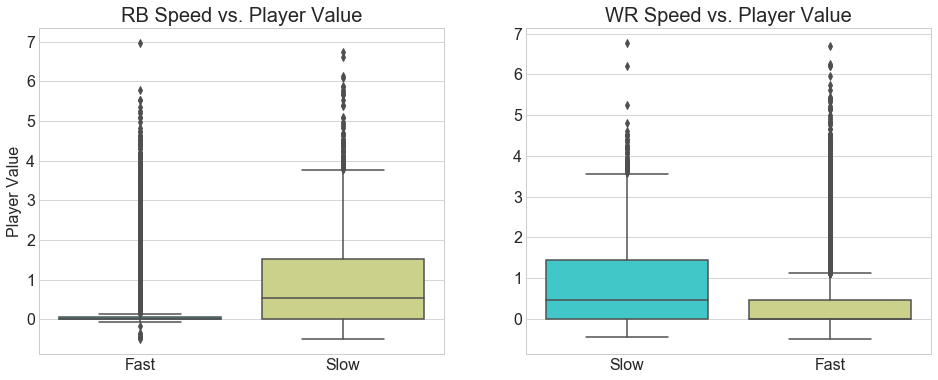

In [109]:
#Subplots of Categorical Features vs Player Value
forty_df = df
forty_df['speed_type'] = np.where(forty_df['forty'] < 4.5 , 'Fast', 'Slow')

f, axes = plt.subplots(ncols=2, figsize=(16,6))

#Plot RB Speed vs. Player Value
forty_df = df[df.pos1_num == 8]
sns.boxplot(data = forty_df, x = 'speed_type', y = 'player_value', palette='rainbow', ax = axes[0])
axes[0].set_title('RB Speed vs. Player Value', fontsize=20)
axes[0].set_ylabel('Player Value', fontsize=16)
axes[0].set_xlabel('', fontsize=16)

#Plot WR Speed vs. Player Value
forty_df = df[df.pos1_num == 10]
sns.boxplot(data = forty_df, x = 'speed_type', y = 'player_value', palette='rainbow', ax = axes[1])
axes[1].set_title('WR Speed vs. Player Value', fontsize=20)
axes[1].set_ylabel('', fontsize=16)
axes[1].set_xlabel('', fontsize=16)

plt.show()

## Player Value by Size

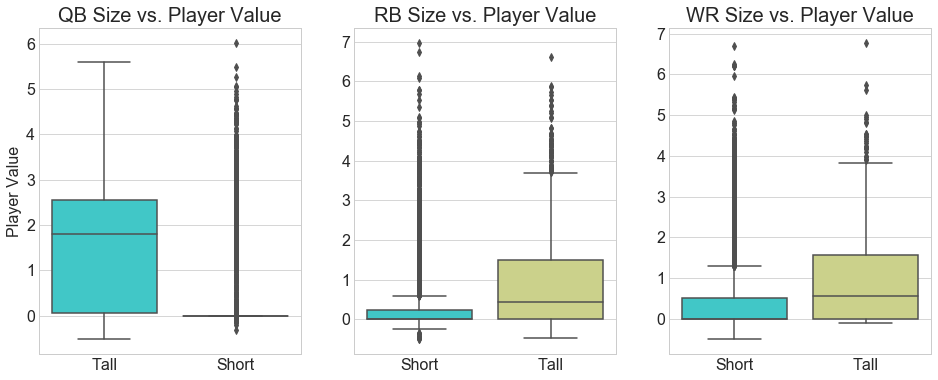

In [110]:
#Subplots of Categorical Features vs Player Value
height_df = df
f, axes = plt.subplots(ncols=3, figsize=(16,6))

#Plot QB Size vs. Player Value
height_df = df[df.pos1_num == 7]
height_df['QB_size'] = np.where(height_df['height'] < 76, 'Short', 'Tall')
sns.boxplot(data = height_df, x = 'QB_size', y = 'player_value', palette='rainbow', ax = axes[0])
axes[0].set_title('QB Size vs. Player Value', fontsize=20)
axes[0].set_ylabel('Player Value', fontsize=16)
axes[0].set_xlabel('', fontsize=16)

#Plot RB Size vs. Player Value
height_df = df[df.pos1_num == 8]
height_df['RB_size'] = np.where(height_df['height'] < 71, 'Short', 'Tall')
sns.boxplot(data = height_df, x = 'RB_size', y = 'player_value', palette='rainbow', ax = axes[1])
axes[1].set_title('RB Size vs. Player Value', fontsize=20)
axes[1].set_ylabel('', fontsize=16)
axes[1].set_xlabel('', fontsize=16)

#Plot WR Size vs. Player Value
height_df = df[df.pos1_num == 10]
height_df['WR_size'] = np.where(height_df['height'] < 75, 'Short', 'Tall')
sns.boxplot(data = height_df, x = 'WR_size', y = 'player_value', palette='rainbow', ax = axes[2])
axes[2].set_title('WR Size vs. Player Value', fontsize=20)
axes[2].set_ylabel('', fontsize=16)
axes[2].set_xlabel('', fontsize=16)

plt.show()

# Run Logistic Regression to get baseline accuracy

In [111]:
#Create function to categorize player actual performance
def playermapper(value_factor):
    if value_factor > .5:
        return 'Yes'
    else:
        return 'No'
    
#Add player selection feature
df['player_selection'] = df.player_value.apply(lambda x: playermapper(x))

#Check distribution of player selection feature
print('-' *x)
print('Player Value Distribution')
print('-' *x)
print(df.player_selection.value_counts('Yes'))
print('-' *x)

---------------------------------------------------------------------------------------------
Player Value Distribution
---------------------------------------------------------------------------------------------
No     0.819753
Yes    0.180247
Name: player_selection, dtype: float64
---------------------------------------------------------------------------------------------


In [ ]:
#Drop y features from X
X_drops = ['player','week','fp2','fp', 'fp3',
           'season_perf_label','recent_perf_label',
          'recent_perf','season_perf',
          'recent_dev','season_dev','player_value',
          'defense_num','speed_type','draft_round',
           'career']

#Create X variable from train and test sets
df.drop(X_drops, inplace=True, axis=1)

X = df.drop('player_selection', axis=1)
y = df['player_selection']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .20, random_state= 0)

#Fit Logistic Regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))

# Final Feature Analysis and Selection

In [ ]:
#Determine feature importance for baseline model
#Scale each feature from 0 to 100.
feature_importance = abs(lr.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())

#Create DataFrame to store and rank featue importance
sorted_idx = np.argsort(feature_importance)
feat_idx = np.array(X_train.columns)[sorted_idx]

feat_ranks = pd.DataFrame(feature_importance[sorted_idx], index=feat_idx)
feat_ranks = feat_ranks.rename(columns={ feat_ranks.columns[0]: 'weight' })
feat_ranks = feat_ranks.sort_values(by=['weight'], ascending=False)

# Plot Most Important Features
feat_top= feat_ranks[feat_ranks['weight'] >= 40]
print(feat_top.shape)

fig = plt.figure(1, figsize=(20,8))
fig = sns.barplot(x='index', y='weight', data=feat_top.weight.reset_index() ,palette='rainbow')

fig.set_title('Baseline Model: Most Important Features', fontsize=24)
fig.set_xlabel('')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, fontsize=16)
fig.set_ylabel('feature weight', fontsize=16)

plt.show()

In [ ]:
#Checked Features for Outliers
fig, axes = plt.subplots(ncols=5, figsize=(20,4))

sns.boxplot(y='proj_rec', data=df, palette='rainbow', ax=axes[0])
axes[0].set_title('Projected Recs', fontsize=14)
axes[0].set_ylabel('', fontsize=14)

sns.boxplot(y='prev_fuml', data=df, palette='rainbow', ax=axes[1])
axes[1].set_title('Previous Fumbles Lost', fontsize=14)
axes[1].set_ylabel('', fontsize=14)

sns.boxplot(y='season_team_fgat', data=df, palette='rainbow', ax=axes[2])
axes[2].set_title('Season Team FGs', fontsize=14)
axes[2].set_ylabel('', fontsize=14)

sns.boxplot(y='recent_stdev_rz_ra', data=df, palette='rainbow', ax=axes[3])
axes[3].set_title('Recent Redzone Rushes', fontsize=14)
axes[3].set_ylabel('', fontsize=14)

sns.boxplot(y='recent_sra', data=df, palette='rainbow', ax=axes[4])
axes[4].set_title('Recent Succ. Rushes', fontsize=14)
axes[4].set_ylabel('', fontsize=14)

plt.show()

In [ ]:
#Checked Features for Outliers
fig, axes = plt.subplots(ncols=5, figsize=(20,4))

sns.boxplot(y='recent_stdev_rz_rec', data=df, palette='rainbow', ax=axes[0])
axes[0].set_title('Recent Redzone Recs', fontsize=14)
axes[0].set_ylabel('', fontsize=14)

sns.boxplot(y='season_rz_rec', data=df, palette='rainbow', ax=axes[1])
axes[1].set_title('Season Redzone Recs', fontsize=14)
axes[1].set_ylabel('', fontsize=14)

sns.boxplot(y='season_stdev_tdrec', data=df, palette='rainbow', ax=axes[3])
axes[2].set_title('Season Stdev Rec TDs', fontsize=14)
axes[2].set_ylabel('', fontsize=14)

sns.boxplot(y='season_stdev_team_tdr', data=df, palette='rainbow', ax=axes[2])
axes[3].set_title('Season Stdev Team Rush TDs', fontsize=14)
axes[3].set_ylabel('', fontsize=14)

sns.boxplot(y='recent_ra', data=df, palette='rainbow', ax=axes[4])
axes[4].set_title('Recent Rushes', fontsize=14)
axes[4].set_ylabel('', fontsize=14)

plt.show()

# Winsorize and Scale X_train

In [ ]:
#Remove features that will not be winsorized or scaled.
not_scaled_train_df = X_train[['year','day_num','stad_num','pos1_num','col_num','dv_num',
              'team_num','surf_num','team_vis','team_home','ou','sprv',
             'height','weight','forty','bench','vertical','broad','shuttle',
             'cone','arm','hand','dpos','start','dcp_x','seas','player_age']]

scaled_cols_train = X_train.columns.difference(not_scaled_train_df.columns)
scaled_train_df = X_train[scaled_cols_train]

#Add feature to capture interaction between fp2 and all variables
cols = scaled_cols_train
for col in cols:
    scaled_train_df[col] = scaled_train_df[col].multiply(scaled_train_df['recent_fp2'], axis="index")

#Drop fp2 feature    
scaled_drops_train = ['prev_fp2','recent_fp2','season_fp2']
scaled_train_df.drop(scaled_drops_train, inplace=True, axis=1)   

#Windorize features to remove outliers
def winsorize_features(cols):
    return mstats.winsorize(cols, limits=[0.5,.05])
X_train = scaled_train_df[scaled_train_df.columns].apply(lambda x: winsorize_features(x))

#Scale features and merge to non-scaled features
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_train = np.concatenate([X_train_minmax, not_scaled_train_df], axis=1)

#Conduct Principal Component Analysis
pca = PCA(n_components=30)
X_transformed_train = pca.fit_transform(X_train)

# Winsorize and Scale X_test

In [ ]:
#Remove features that will not be winsorized or scaled.
not_scaled_test_df = X_test[['year','day_num','stad_num','pos1_num','col_num','dv_num',
              'team_num','surf_num','team_vis','team_home','ou','sprv',
             'height','weight','forty','bench','vertical','broad','shuttle',
             'cone','arm','hand','dpos','start','dcp_x','seas','player_age']]

scaled_cols_test = X_test.columns.difference(not_scaled_test_df.columns)
scaled_test_df = X_test[scaled_cols_test]

#Add feature to capture interaction between fp2 and all variables
cols = scaled_cols_train
for col in cols:
    scaled_test_df[col] = scaled_test_df[col].multiply(scaled_test_df['recent_fp2'], axis="index")
    
#Drop fp2 feature 
scaled_drops_test = ['prev_fp2','recent_fp2','season_fp2']
scaled_test_df.drop(scaled_drops_test, inplace=True, axis=1)

#Windorize features to remove outliers
def winsorize_features(cols):
    return mstats.winsorize(cols, limits=[0.5,.05])
X_test = scaled_test_df[scaled_test_df.columns].apply(lambda x: winsorize_features(x))

#Scale features and merge to non-scaled features
min_max_scaler = preprocessing.MinMaxScaler()
X_test_minmax = min_max_scaler.fit_transform(X_test)
X_test = np.concatenate([X_test_minmax, not_scaled_test_df], axis=1)

#Conduct Principal Component Analysis
pca = PCA(n_components=30)
X_transformed_test = pca.fit_transform(X_test)

# Evaluate Model on Test Data

In [ ]:
#Fit Logistic Regression Model
lr.fit(X_transformed_train, y_train)
print('Logistic Regression:', round(lr.score(X_transformed_test,y_test) *100,2),'%')

#Fit Random Forest Classifer
rf = RandomForestClassifier()
rf.fit(X_transformed_train, y_train)
print('Random Forest:', round(rf.score(X_transformed_test,y_test) *100,2),'%')

#Fit Gradient Boosting Classifer
gb = GradientBoostingClassifier()
gb.fit(X_transformed_train, y_train)
print('Gradient Boosting:', round(gb.score(X_transformed_test,y_test) *100,2),'%')

#Fit K Nearest Neighbors Classifer
knn = KNeighborsClassifier()
knn.fit(X_transformed_train, y_train)
print('K Nearest Neighbors:', round(knn.score(X_transformed_test,y_test) *100,2),'%')

#Fit Decision Tree Classifer
dtc = DecisionTreeClassifier()
dtc.fit(X_transformed_train, y_train)
print('Decision Tree:', round(dtc.score(X_transformed_test,y_test) *100,2),'%')

#Fit XGBoost Classifer
clf = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
clf.fit(X_transformed_train, y_train)
print('XGBoost: ', round(clf.score(X_transformed_test,y_test) *100,2),'%')

#Fit Ridge Classifer
rig = RidgeClassifier() 
rig.fit(X_transformed_train, y_train)
print('Ridge Accuracy:', round(rig.score(X_transformed_test,y_test) *100,2),'%')

# Plot Confusion Matrix for top models

In [ ]:
#Get y_pred for all classifers
y_pred_lr = lr.predict(X_transformed_test)
y_pred_gb = gb.predict(X_transformed_test)
y_pred_clf = clf.predict(X_transformed_test)
y_pred_rig = rig.predict(X_transformed_test)

#Get confusion matrix for all classifers
lr_cm = confusion_matrix(y_test, y_pred_lr)
gb_cm = confusion_matrix(y_test, y_pred_gb)
clf_cm = confusion_matrix(y_test, y_pred_clf)
rig_cm = confusion_matrix(y_test, y_pred_rig)

#Setup Confusion Matrix Plots
fig, ax = plt.subplots(2, 2,figsize=(26,16))
labels = ['No', 'Yes']

#Logisitic Regression Confusion Matrix
sns.heatmap(lr_cm, ax=ax[0][0], annot=True, annot_kws={"size": 20}, cmap=plt.cm.copper)
ax[0][0].set_title("Logistic Regression \n Confusion Matrix", fontsize=24)
ax[0][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

#Gradient Boosting Confusion Matrix
sns.heatmap(gb_cm, ax=ax[0][1], annot=True, annot_kws={"size": 20}, cmap=plt.cm.copper)
ax[0][1].set_title("Gradient Boosting \n Confusion Matrix", fontsize=24)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

#XGBoost Confusion Matrix
sns.heatmap(clf_cm, ax=ax[1][0], annot=True, annot_kws={"size": 20}, cmap=plt.cm.copper)
ax[1][0].set_title("XGBoost \n Confusion Matrix", fontsize=24)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

#Ridge Classifer Confusion Matrix
sns.heatmap(rig_cm, ax=ax[1][1], annot=True, annot_kws={"size": 20}, cmap=plt.cm.copper)
ax[1][1].set_title("Ridge Classifer \n Confusion Matrix", fontsize=24)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.show()

# Fit Voting Classier and Plot Final Confusion Matrix

In [ ]:
#Voting Classifer Confusion Matrix
plt.figure(figsize=(12,8))
vc_cm = confusion_matrix(y_test, y_pred_vc)
sns.heatmap(vc_cm, annot=True, annot_kws={"size":14 }, cmap=plt.cm.copper)

plt.title('Voting Classifer \n Confusion Matrix', fontsize=16)
plt.xticks(fontsize = 0)
plt.yticks(fontsize = 0)

plt.show()

In [ ]:
#Use Voting Classifer 
vc = VotingClassifier(estimators=[('lr', lr), ('rf', rf),('gb',gb) ,('clf',clf),('rig', rig)], voting='hard')
vc.fit(X_transformed_train, y_train)
print('Voting Classifer: ', round(vc.score(X_transformed_test,y_test) *100,2),'%')

#Print Classification Report
y_pred_vc = vc.predict(X_transformed_test)
target_names = ['No','Yes']
print(classification_report(y_test, y_pred_vc, target_names=target_names))

# Limitations & Next Steps
    * Time Series is ideal for this project
    * Use oversampling for unbalanced data
    * Add player injury information to model
    * Build separate models for each position